In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from struct import iter_unpack

In [2]:
def read(path):
    with open(path, 'rb') as f:
        return [x for x in iter_unpack('<Lff', f.read())]

In [3]:
solar = pd.DataFrame(read('./data/solar'), columns=['datetime', 'voltage (V)', 'current (mA)'])
battery = pd.DataFrame(read('./data/battery'), columns=['datetime', 'voltage (V)', 'current (mA)'])
# solar = solar[solar['datetime']>0]
# battery = battery[battery['datetime']>0]
for x in [solar, battery]:
    x['datetime'] = pd.to_datetime(x['datetime'], unit='s')
    x['power (mW)'] = x['voltage (V)'] * x['current (mA)']

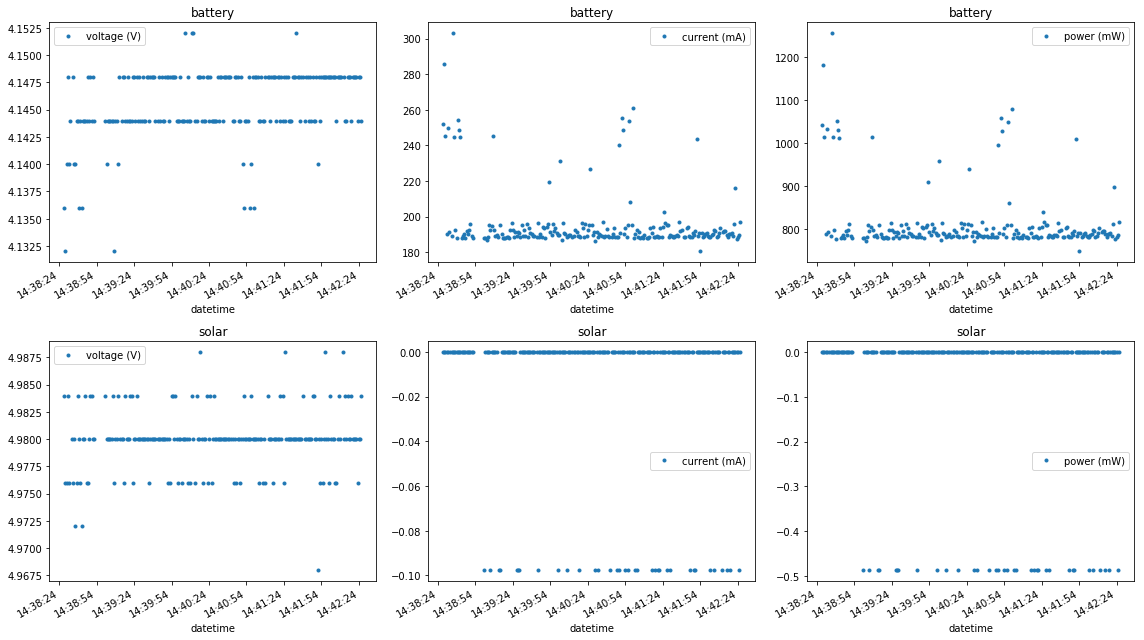

In [4]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16,9))

for i,x in enumerate([battery, solar]):
    for j in range(3):
        axes[i,j].set_title(['battery', 'solar'][i])
    x.plot(x='datetime', y='voltage (V)', ax=axes[i,0], linestyle='none', marker='.')
    x.plot(x='datetime', y='current (mA)', ax=axes[i,1], linestyle='none', marker='.')
    x.plot(x='datetime', y='power (mW)', ax=axes[i,2], linestyle='none', marker='.')

plt.tight_layout()
plt.show()